# Navie-Bayes on ionosphere dataset

**OBS**: [dataset information](https://archive.ics.uci.edu/dataset/52/ionosphere)

***

**Additional Information**
This radar data was collected by a system in Goose Bay, Labrador.  This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  See the paper for more details.  The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere.  "Bad" returns are those that do not; their signals pass through the ionosphere.  

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number.  There were 17 pulse numbers for the Goose Bay system.  Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

**Has Missing Values?**
No

***

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

url = "./heart_preprocessed_naive_bayes.csv"
df = pd.read_csv(url)
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_High,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_High,stress_level_Low,stress_level_Moderate,EKG_results_Abnormal,EKG_results_Normal
0,-0.381345,-0.651288,2.018576,-2.391026,-0.579876,-0.078690,-0.650198,1.198725,0.836023,-1.041414,...,0,1,1,0,0,0,0,1,0,1
1,-0.130795,1.535343,2.018576,0.560816,-0.579876,0.165197,1.537916,1.382036,0.370439,1.153094,...,0,1,0,1,0,1,0,0,0,1
2,0.704371,-0.651288,-0.495374,0.182375,-0.579876,-0.383549,-0.650198,-0.706210,0.969047,0.055840,...,0,1,0,0,1,0,0,1,0,1
3,-0.715412,-0.651288,-0.495374,-0.902490,-0.579876,-0.932294,-0.650198,-1.357536,-1.425386,1.053344,...,0,1,1,0,0,1,0,0,0,1
4,0.537338,-0.651288,-0.495374,-0.826802,-0.579876,0.835886,-0.650198,-1.594181,-0.361194,-0.542662,...,0,1,0,1,0,0,0,1,0,1


In [18]:
# OBS: in the original method it was used 'as_matrix' for extracting the data, but is deprecated
X = df.drop(columns=["heart_attack"], axis = 1).values
y = df["heart_attack"].values.astype(np.int8)

print(X.shape)
print(y.shape)
print(f"Dataset: {X.shape}  |  positives {(y==1).sum()}")

(20000, 42)
(20000,)
Dataset: (20000, 42)  |  positives 8025


In [19]:
# Train on data. No parameters to adjust
from sklearn.naive_bayes import GaussianNB       ### Because continuous data
from sklearn.model_selection import (
    StratifiedKFold, 
    cross_val_score, 
    train_test_split
)
import sklearn.neighbors as nb

# OBS: deleted 'random_state' parameter since its use is no longer needed
cv = StratifiedKFold(
    n_splits = 10, 
) 

gnb = GaussianNB()
cv_scores = cross_val_score(
    gnb,
    X = X,
    y = y,
    cv = cv
)
np.mean(cv_scores)  # Mean score of the executions

np.float64(0.72015)

In [20]:
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score, confusion_matrix

predicted = cross_val_predict(
    estimator = GaussianNB(), 
    X = X,
    y = y,  
    cv = cv
)  

print(confusion_matrix(y, predicted))  # Confusion matrix
print(accuracy_score(y, predicted))    # Accuracy compute using both, true value and prediction

[[9200 2775]
 [2822 5203]]
0.72015


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     11975
           1       0.65      0.65      0.65      8025

    accuracy                           0.72     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.72      0.72      0.72     20000



***
## Adjusting probability threshold

In [22]:
# Focus on predict class 1
y2 = y.copy()  # Since data is already in 0s and 1s, just make a copy

# Split the data
(X_train, X_test, y_train, y_test) = train_test_split(X, y2, test_size=0.3, random_state=1)


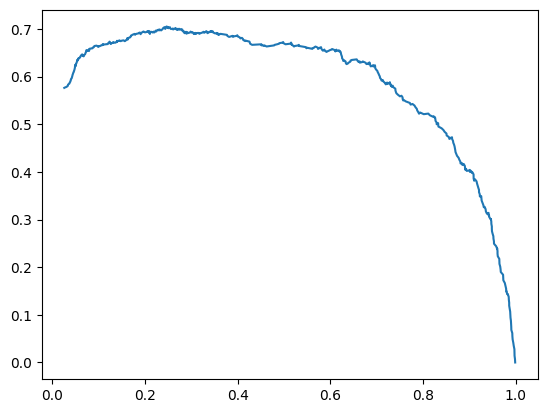

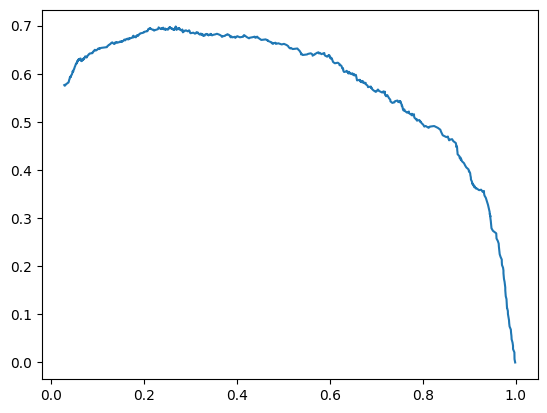

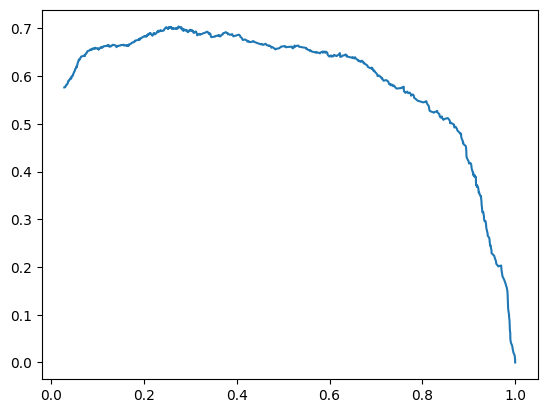

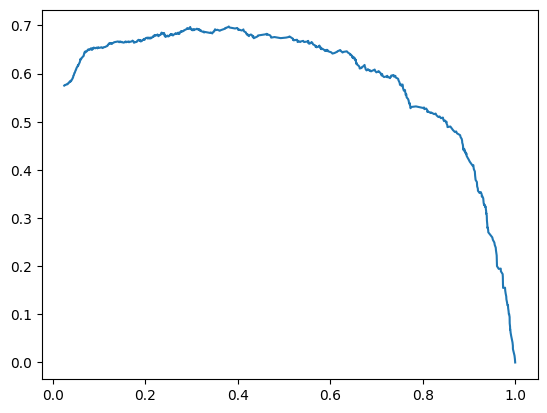

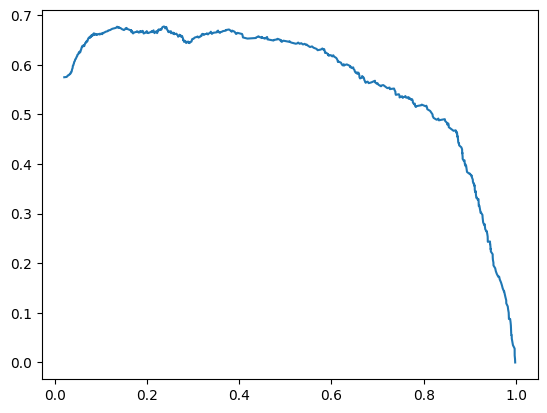

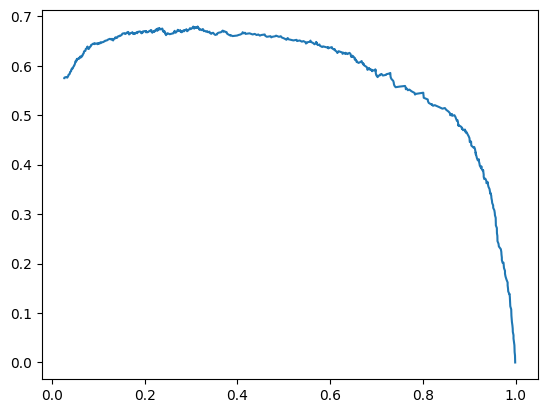

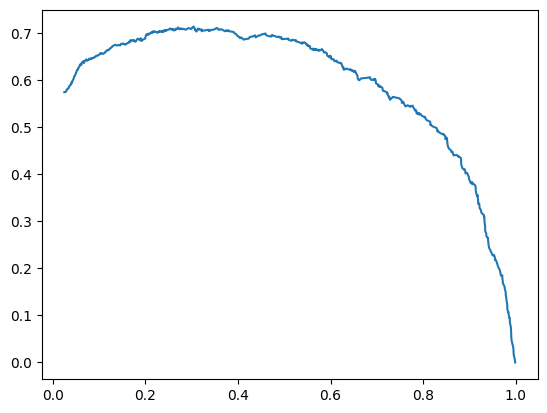

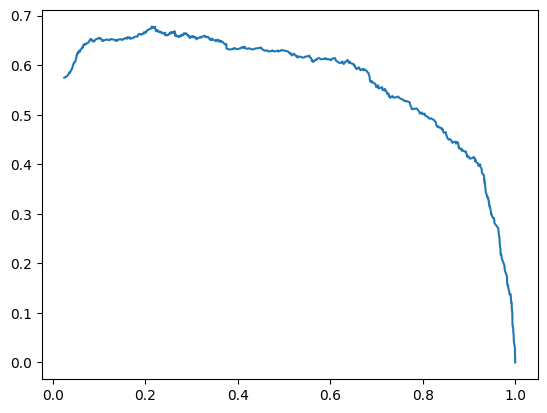

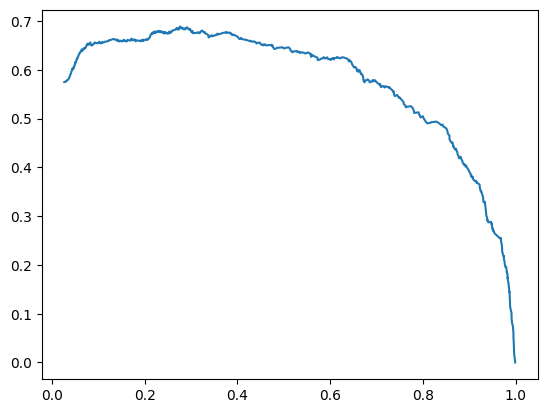

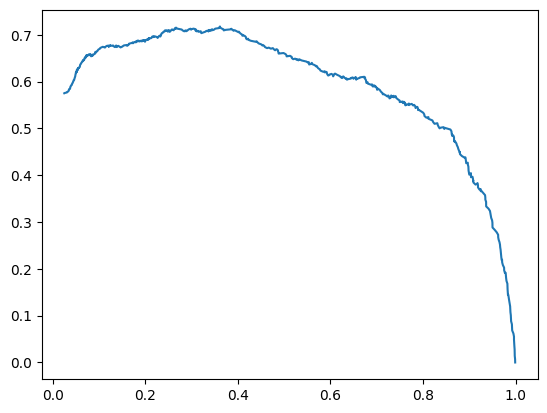

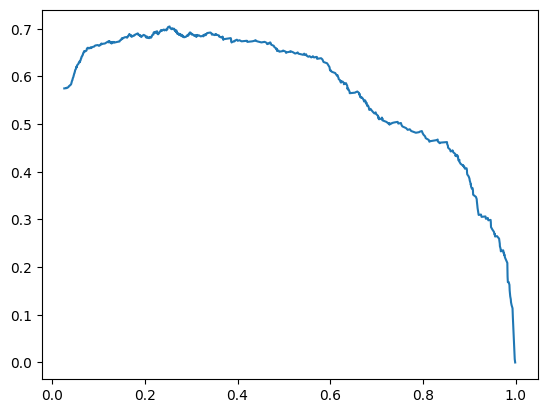

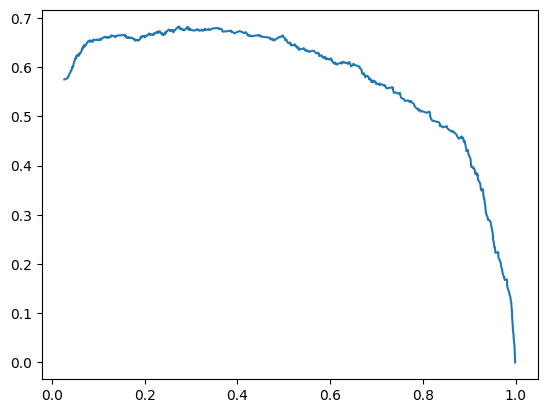

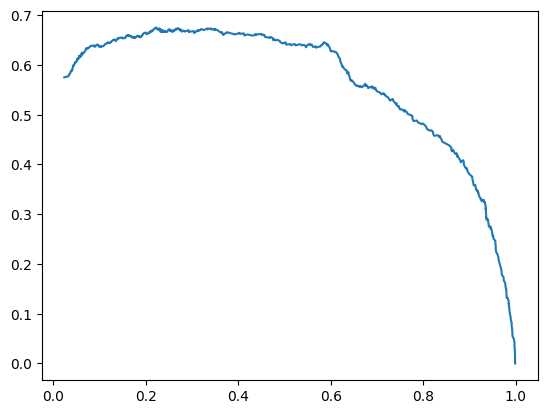

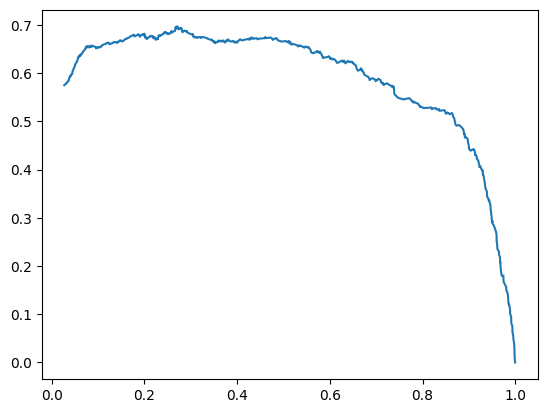

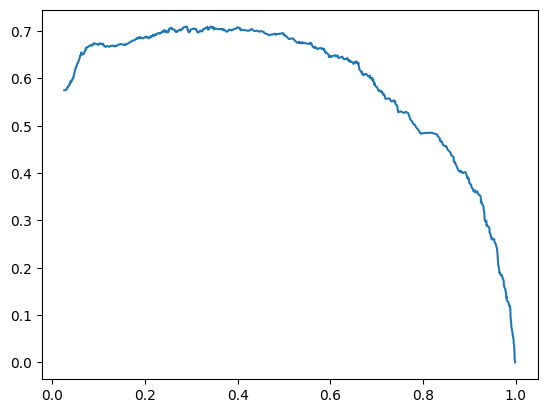

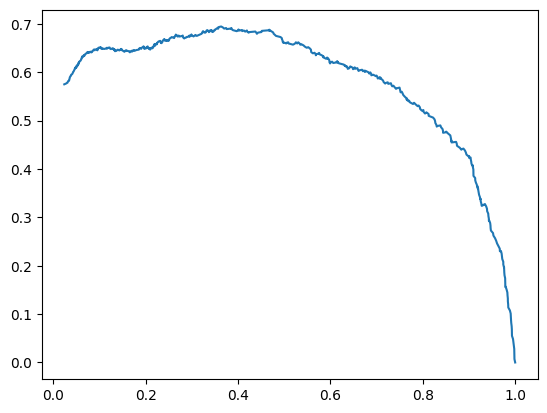

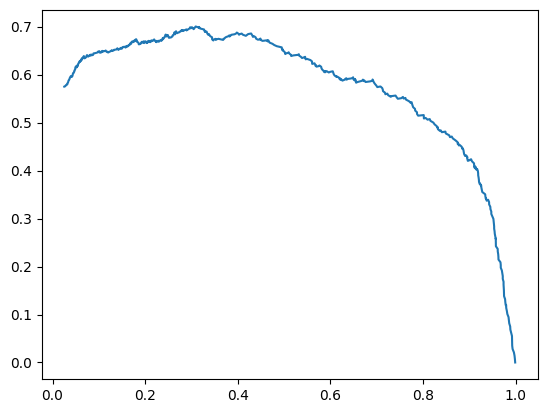

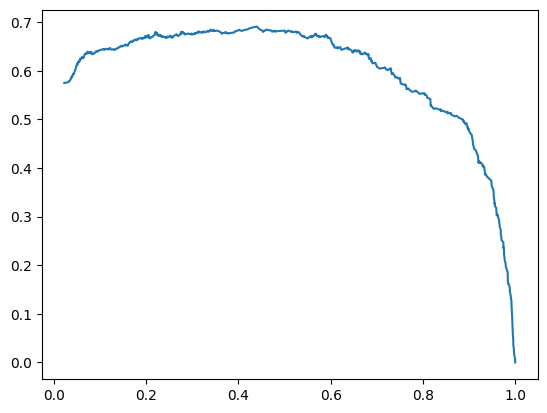

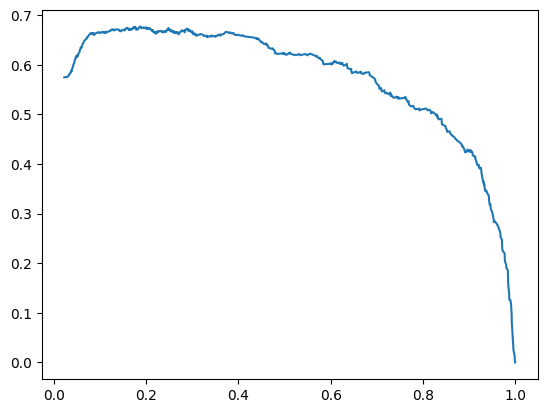

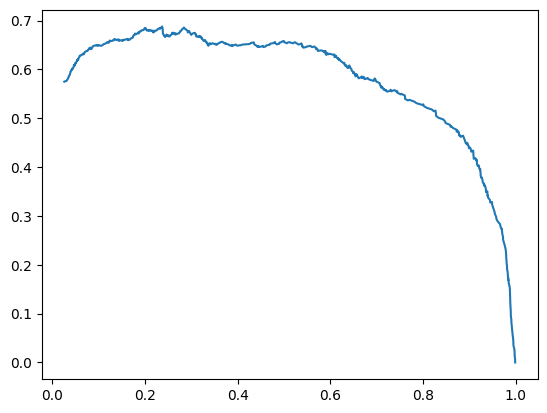

Selected threshold in 10-fold cross validation: 0.286234


In [23]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def filterp(th,ProbClass1):
    """Given a threshold "th" and a set of probabilities of belonging to class 1 "ProbClass1", 
    return predictions.""" 
    y = np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf = GaussianNB()
lth=[]

# We do a 10-fold cross-validation with 10 iterations
kf = StratifiedKFold(
    n_splits = 20, 
    shuffle = True, 
    random_state = 42
)

# Now we compute the threshold by iterating the data we have
for train_index, test_index in kf.split(X_train, y_train):
    # Use X_train instead of X
    X_train2, X_test2 = X_train[train_index], X_train[test_index]
    y_train2, y_test2 = y_train[train_index], y_train[test_index]
    
    clf.fit(X_train2, y_train2)
    probs = clf.predict_proba(X_test2)
    ProbClass1 = probs[:,1]  # This should work now as GaussianNB always returns probabilities for both classes
    
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold)
    res = np.array([[th,f1_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])
    
    # Uncomment the following lines if you want to plot at each iteration how f1-score
    # evolves increasing the threshold 
    plt.plot(res[:,0],res[:,1])
    plt.show()

    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 10 iterations    
threshold = np.mean(lth)
print(f"Selected threshold in 10-fold cross validation: {np.round(threshold, 6)}")

In [24]:
# Train a classifier with the whole training data 
clf = GaussianNB()
clf.fit(X_train, y_train)

# Obtain probabilities for data on test set
probs = clf.predict_proba(X_test)

# Generate predictions using probabilities and threshold found on 10 folds cross-validation
prediction = filterp(threshold,probs[:,1])

print(classification_report(y_test, prediction))
# Ignore warnings explaining that in some iterations f1 score is 0

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      3618
           1       0.57      0.77      0.66      2382

    accuracy                           0.68      6000
   macro avg       0.69      0.70      0.68      6000
weighted avg       0.71      0.68      0.68      6000



In [25]:
clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      3618
           1       0.63      0.62      0.63      2382

    accuracy                           0.70      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.70      0.70      0.70      6000

